In [4]:
import maboss
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../../')
from maboss_visualize import *

In [5]:
# Setup the name of the files
model_files = "../../model/bcrn_to_maboss/test_net_v2"

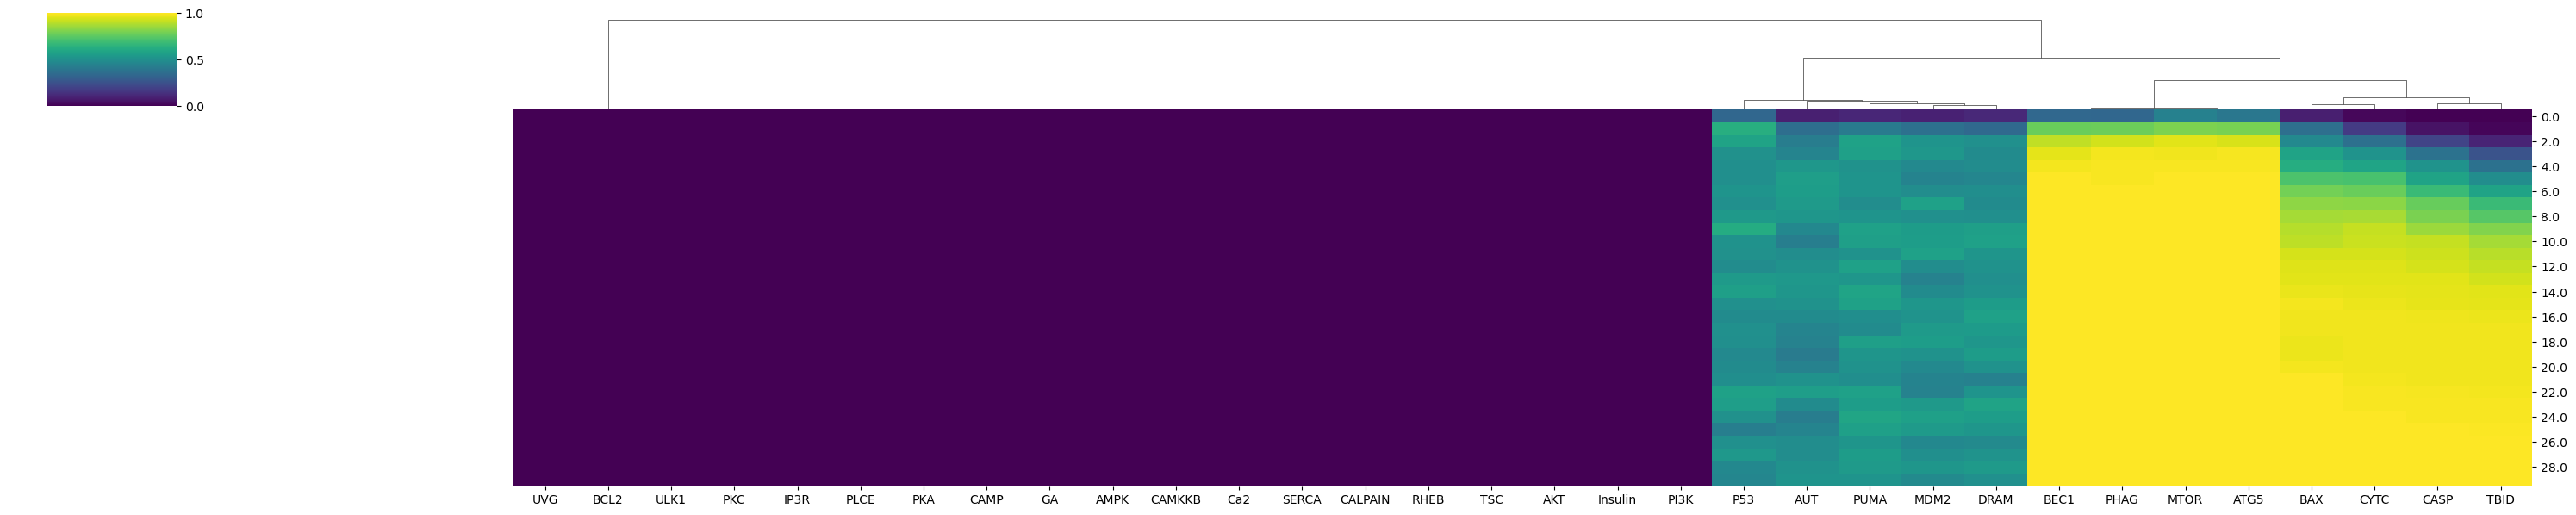

In [6]:
## Set up the required files
bnd_file = model_files +".bnd"
cfg_CRC = model_files + ".cfg"

## Load 
# MaBoSS model
CRC = maboss.load(bnd_file, cfg_CRC)

## modify the max_time if necessary
model = maboss.copy_and_update_parameters(CRC, {'max_time':30,
                                                        'time_tick':1})
model.update_parameters(sample_count = 100,
                                thread_count = 15)

## Put all inputs to random
for i in model.network.names:
    model.network.set_istate(i,[1,0])


## Set output nodes
model.network.set_output(model.network.names)

## Run MaBoSS simulation and obtain the results
result_allinputs = model.run()
df_res = result_allinputs.get_nodes_probtraj()

## Plot the simulation results
sns.clustermap(df_res, cmap="viridis", figsize=(30,6), row_cluster = False)

In [ ]:
# Setup the model name and the network path
network_path = model_files + '.xgmml'

# Load the network into the maboss_visualizer tool
network = Net_visualizer()
network.load_network_xgmml(network_path)

network.load_timeseries(df_res)
network.create_networkactivity_animation(number_of_frames=25,
                                         frame_duration=75, 
                                         file_name='Autophagy_and_apoptosis_allinputs', 
                                         figure_size = (20,12))

Network loaded : ../../model/bcrn_to_maboss/test_net_v2.xgmml
Generating frames for the GIF...


100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


GIF animation saved at Autophagy_and_apoptosis_allinputs.gif.gif


Apoptosis_base_activity = 0.0
Proliferation_base_activity = 1.0
O_stress_base_activity = 0.0
Growth_factor_base_activity = 1.0
TNF_R_or_DR_base_activity = 0.516
AA_Starvation_base_activity = 0.0
NFE2L2_base_activity = 1.0
KEAP1_base_activity = 0.0
GSK3A_base_activity = 0.0
NQO1_base_activity = 0.0
STK11_base_activity = 0.0
AHSA1_base_activity = 0.0
ATM_base_activity = 0.0
Ulk_C_base_activity = 0.0
p21_base_activity = 0.0
TP53_nuc_base_activity = 0.0
FOXO_base_activity = 0.0
MTOR_base_activity = 1.0
ATG13_base_activity = 0.0
RB1CC1_base_activity = 1.0
TP53_cyto_base_activity = 0.0
ULK1_base_activity = 0.0
PRKA_base_activity = 0.0
EIF2AK3_base_activity = 0.0
RPTOR_base_activity = 1.0
TSC2_base_activity = 0.0
AMBRA1_base_activity = 0.0
MDM2_base_activity = 0.7430000000000001
BCL2_BECN1_C_base_activity = 0.0
BECN1_base_activity = 0.0
AKT1_base_activity = 0.7430000000000001
PIK3CA_base_activity = 0.7430000000000001
RRAGA_base_activity = 1.0
ATG14_base_activity = 0.0
PIK3C3_base_activity = 0

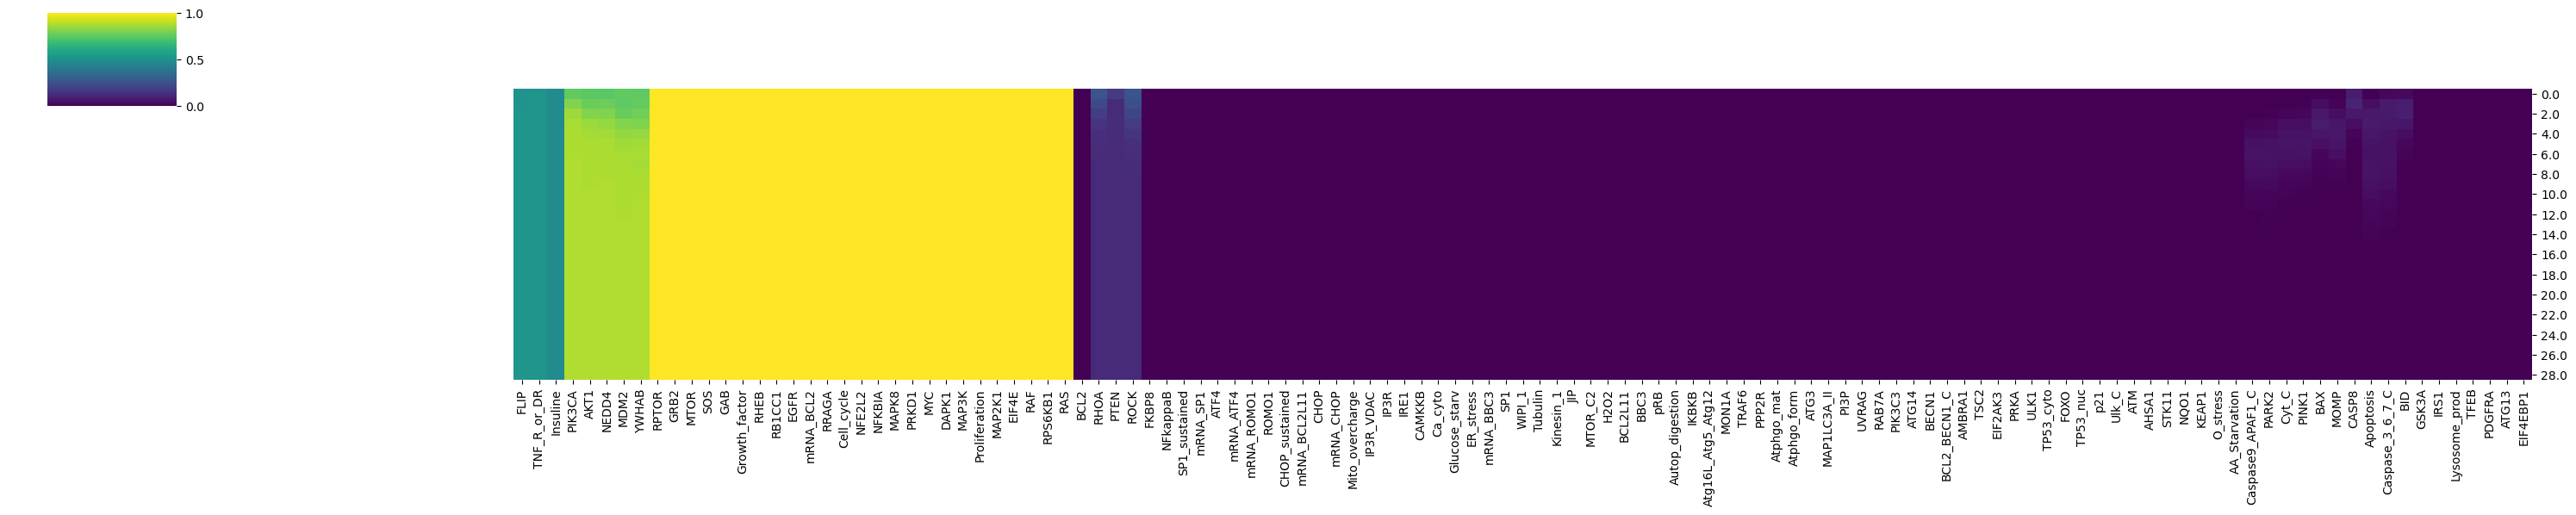

In [ ]:
base_activity = df_res.loc[28,:]
for i in base_activity.index:
    print(i + '_base_activity = ' + str(base_activity[i]))

base_simulation = model.copy()
for i in base_activity.index:
    base_simulation.network.set_istate(i, [1-base_activity[i], base_activity[i]])

## Run MaBoSS simulation and obtain the results
results_baseline = base_simulation.run()
df_baseline_res = results_baseline.get_nodes_probtraj().copy()

## Plot the simulation results
sns.clustermap(df_baseline_res[column_order], cmap="viridis", figsize=(30,6), row_cluster = False, col_cluster = False)

# Run model perturbation

In [15]:
# Define target nodes for perturbation (exclude static nodes)
target_nodes = list(set(model.network.names))

# Perform baseline simulation
result = model.run()
df_baseline_res = result.get_nodes_probtraj().copy()
df_baseline_res['mutation'] = 'wildtype'
df_baseline_res['timepoint'] = df_baseline_res.index
df_baseline_res['mutation_type'] = 'None'

# Store all mutation results
mutation_results = {}
mutation_results['wildtype'] = df_baseline_res

# Perturb each target node to OFF one at a time
for i in tqdm(target_nodes):
    #print(f"Mutating {i} to OFF...")
    
    # Create a copy of the model and mutate
    model_mut = maboss.copy_and_mutate(model, [i], "OFF")
    
    # Run simulation
    res_mut = model_mut.run()
    
    # Get probability trajectory
    df_res_mut = res_mut.get_nodes_probtraj().copy()
    df_res_mut['mutation'] = i + '_OFF'
    df_res_mut['timepoint'] = df_res_mut.index
    df_res_mut['mutation_type'] = 'OFF'

    # Store results with mutation name as key
    mutation_results[i + '_OFF'] = df_res_mut

# Perturb each target node to ON one at a time
for i in tqdm(target_nodes):
    #print(f"Mutating {i} to ON...")
    
    # Create a copy of the model and mutate
    model_mut = maboss.copy_and_mutate(model, [i], "ON")
    
    # Run simulation
    res_mut = model_mut.run()
    
    # Get probability trajectory
    df_res_mut = res_mut.get_nodes_probtraj().copy()
    df_res_mut['mutation'] = i + '_ON'
    df_res_mut['timepoint'] = df_res_mut.index
    df_res_mut['mutation_type'] = 'ON'

    # Store results with mutation name as key
    mutation_results[i + '_ON'] = df_res_mut

# Each mutation becomes a separate column or can be accessed individually
print(f"Completed {len(target_nodes)} mutations")
#print(f"Available results: {list(mutation_results.keys())}")

100%|██████████| 32/32 [00:05<00:00,  5.52it/s]

Completed 32 mutations


In [16]:
df_all_mutations = pd.concat(mutation_results.values(), ignore_index=True)

# Simulation projection

In [17]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Initialize PCA (let's reduce to 2 principal components for this example)
pca = PCA(n_components=10)

# Fit and transform the data
df_pca = df_all_mutations.drop(['mutation','timepoint','mutation_type'], axis = 1) 
pca_result = pca.fit_transform(df_pca)

# Convert the result back to a DataFrame for easier interpretation
pca_df = pd.DataFrame(data=pca_result, index=df_pca.index)

# number pca column
number_list = list(range(pca_result.shape[1]))
str_list = [str(i+1) for i in number_list]
pca_df.columns = ['pc' + s for s in str_list]

# Add model_id and timepoint backinto dataframe
pca_df['mutation'] = df_all_mutations['mutation']
pca_df['timepoint'] = df_all_mutations['timepoint'].astype('float')
pca_df['mutation_type'] = df_all_mutations['mutation_type']

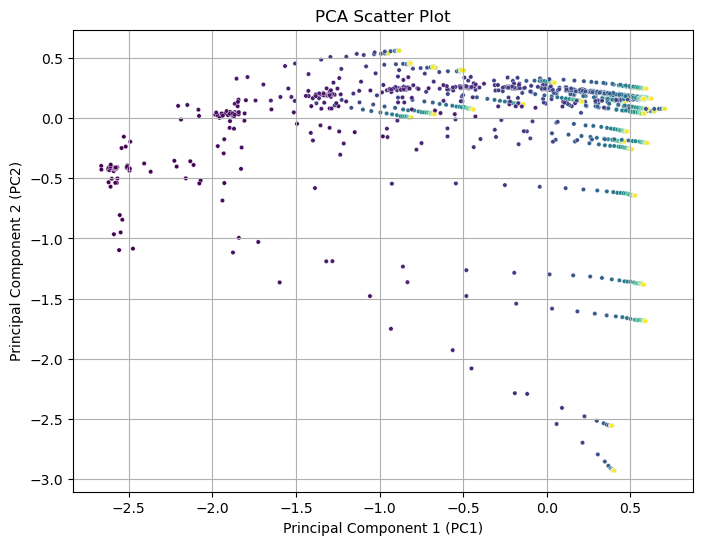

In [19]:
plt.figure(figsize=(8, 6))

# Scatter plot using Seaborn
sns.scatterplot(data = pca_df, x='pc1', y='pc2', s=10, hue = 'timepoint', palette='viridis', legend=None)

# Add title and labels
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Display the plot
plt.grid(True)
plt.show()

/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spankaew/anaconda3/envs/network_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/spankaew/anaconda3/envs/network_analysis/lib/pytho

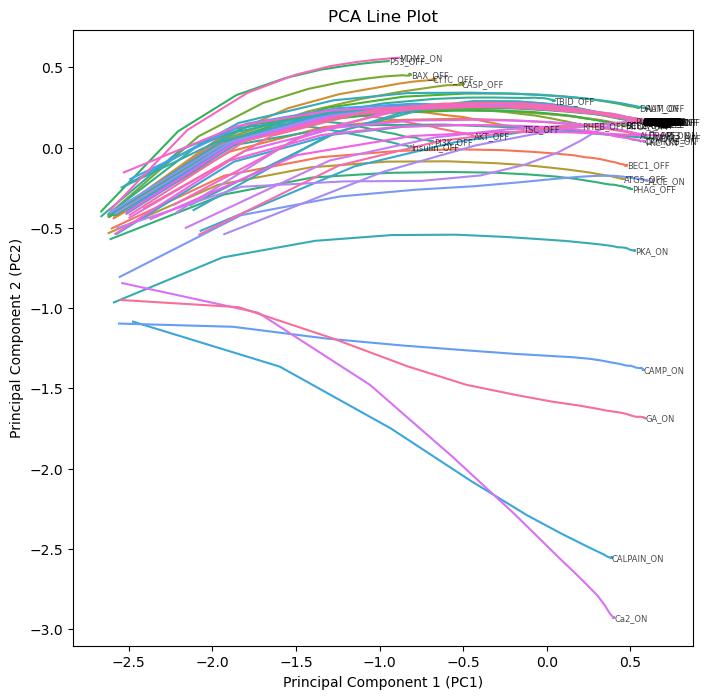

In [20]:
plt.figure(figsize=(8, 8))

# Line plot using Seaborn
sns.lineplot(data = pca_df, x='pc1', y='pc2',
             units = 'mutation', estimator=None,
             hue = 'mutation', legend=None, sort=False)

# Add title and labels
plt.title('PCA Line Plot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Add labels at the end of each line
for mutation in pca_df['mutation'].unique():
    mutation_data = pca_df[pca_df['mutation'] == mutation]
    last_point = mutation_data.iloc[-1]
    plt.text(last_point['pc1'], last_point['pc2'], mutation, fontsize=6, ha='left', va='center', alpha=0.7)

# Display the plot
#plt.grid(True)
plt.show()

In [21]:
# Subset the BECN1_OFF mutation
test_visualization = df_all_mutations[df_all_mutations['mutation']=='Ca2_ON'].copy()
test_visualization = test_visualization.drop(['mutation','timepoint','mutation_type'], axis = 1)
test_visualization = test_visualization.reset_index(drop=True)

# Setup the name of the files
model_files = "/home/spankaew/Git/autophagy/model/bcrn_to_maboss/test_net_v2"

# Setup the model name and the network path
network_path = model_files + '.xgmml'

# Load the network into the maboss_visualizer tool
network = Net_visualizer()
network.load_network_xgmml(network_path)

network.load_timeseries(test_visualization)
network.create_networkactivity_animation(number_of_frames=25,
                                         frame_duration=75, 
                                         file_name='base_Ca2_ON', 
                                         figure_size = (20,12))

Network loaded : /home/spankaew/Git/autophagy/model/bcrn_to_maboss/test_net_v2.xgmml
Generating frames for the GIF...


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


GIF animation saved at base_Ca2_ON.gif


In [14]:
# Subset the BECN1_OFF mutation
test_visualization = df_all_mutations[df_all_mutations['mutation']=='BECN1_ON'].copy()
test_visualization = test_visualization.drop(['mutation','timepoint','mutation_type'], axis = 1)
test_visualization = test_visualization.reset_index(drop=True)

# Setup the name of the files
model_files = "/home/spankaew/Git/autophagy/model/Autophagy_and_apoptosis"

# Setup the model name and the network path
network_path = model_files + '.xgmml'

# Load the network into the maboss_visualizer tool
network = Net_visualizer()
network.load_network_xgmml(network_path)

network.load_timeseries(test_visualization)
network.create_networkactivity_animation(number_of_frames=25,
                                         frame_duration=75, 
                                         file_name='Autophagy_proliferation_BECN1_ON', 
                                         figure_size = (20,12))

Network loaded : /home/spankaew/Git/autophagy/model/Autophagy_and_apoptosis.xgmml
Generating frames for the GIF...


100%|██████████| 25/25 [00:41<00:00,  1.67s/it]


GIF animation saved at Autophagy_proliferation_BECN1_ON.gif
